# Trains a diffusion model on CIFAR-10 (version 2).

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

The model is a denoising diffusion probabilistic model (https://arxiv.org/abs/2006.11239), which is trained to reverse a gradual noising process, allowing the model to generate samples from the learned data distribution starting from random noise. DDIM-style deterministic sampling (https://arxiv.org/abs/2010.02502) is also supported. This model is also trained on continuous timesteps parameterized by the log SNR on each timestep (see Variational Diffusion Models, https://arxiv.org/abs/2107.00630), allowing different noise schedules than the one used during training to be easily used during sampling. It uses the 'v' objective from Progressive Distillation for Fast Sampling of Diffusion Models (https://openreview.net/forum?id=TIdIXIpzhoI) for better conditioned denoised images at high noise levels, but reweights the loss function so that it has the same relative weighting as the 'eps' objective.

In [1]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [1]:
# Check the GPU type

!nvidia-smi

Wed Sep 10 14:10:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 6000                Off |   00000000:65:00.0  On |                  Off |
| 34%   39C    P5             37W /  260W |    1562MiB /  24576MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [2]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [3]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        # The inputs to timestep_embed will approximately fall into the range
        # -10 to 10, so use std 0.2 for the Fourier Features.
        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, dropout_last=False),
        )

    def forward(self, input, log_snrs, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [4]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    return -torch.special.expm1(1e-4 + 10 * t**2).log()


@torch.no_grad()
def sample(model, x, steps, eta, classes):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i], classes).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


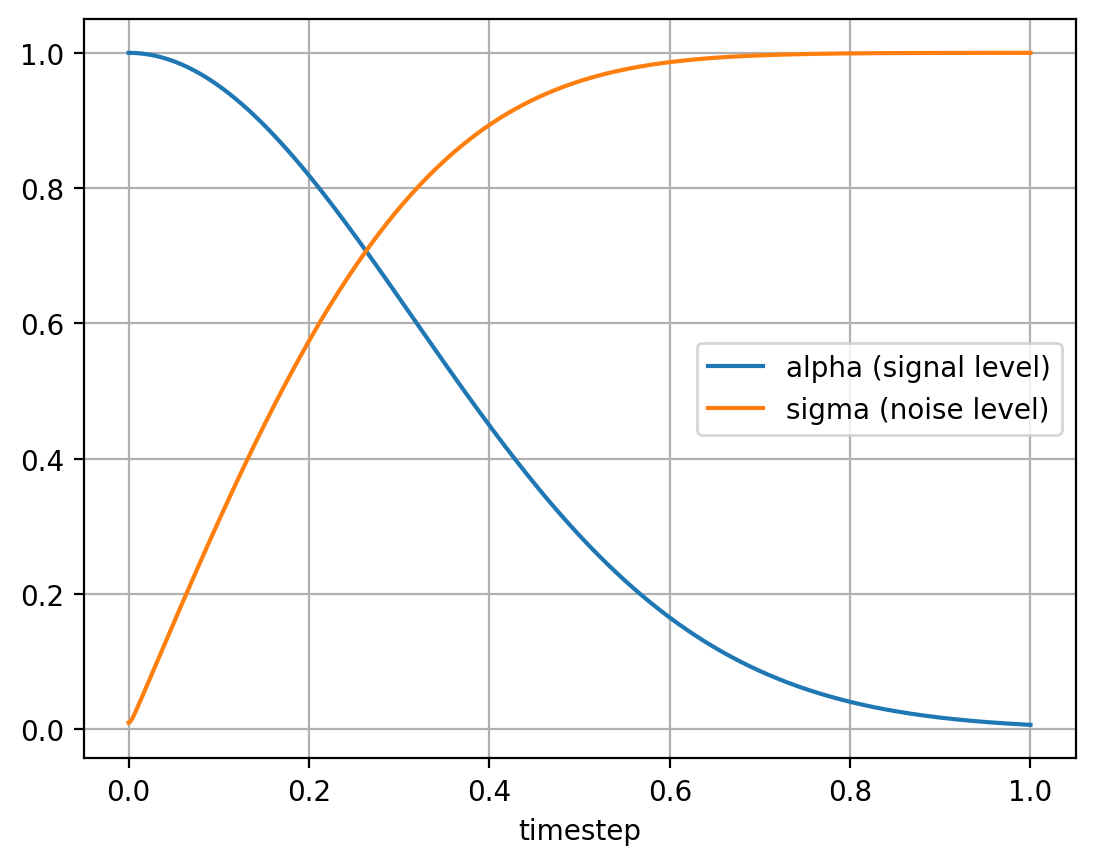

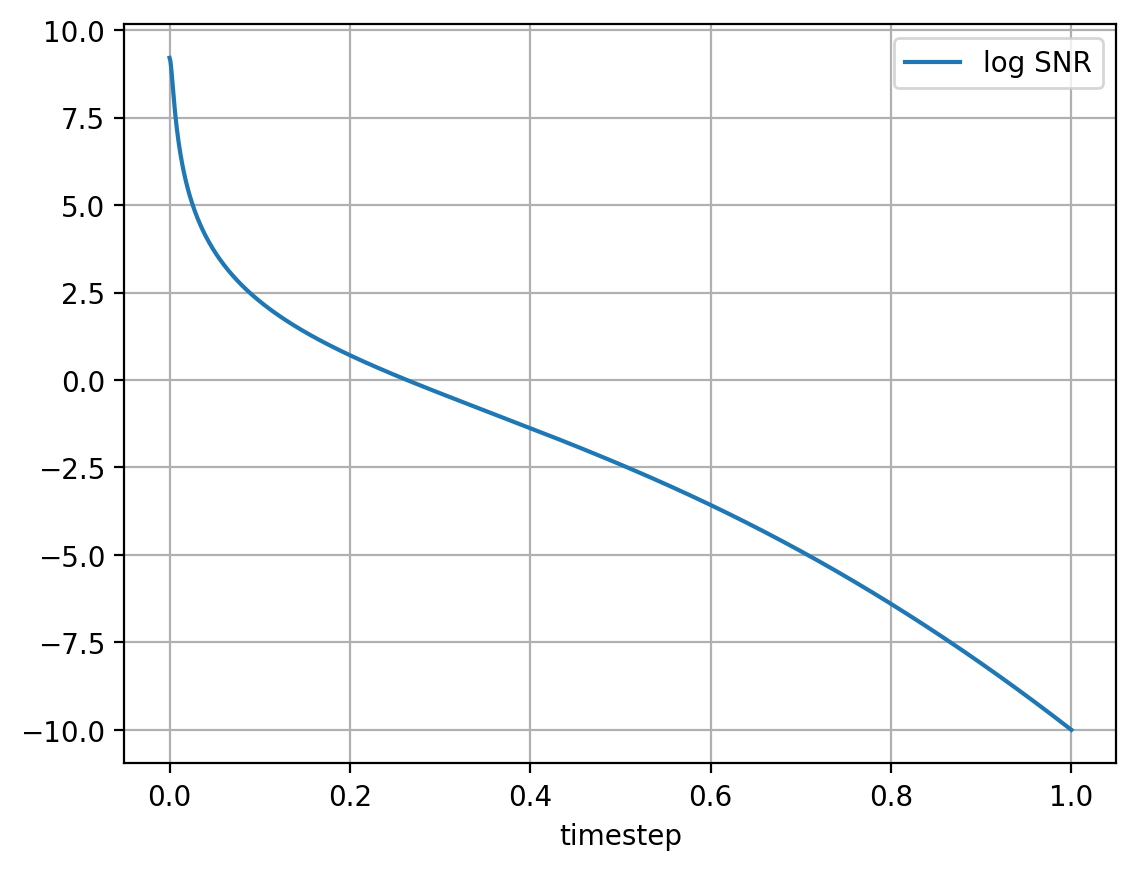

In [5]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
log_snrs_vis = get_ddpm_schedule(t_vis)
alphas_vis, sigmas_vis = get_alphas_sigmas(log_snrs_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()

plt.plot(t_vis, log_snrs_vis, label='log SNR')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [6]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('../data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('../data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)


In [7]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 23211315



Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_70806/1869076828.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation: Epoch: 0, loss: 0.224324

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_70806/2978596345.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


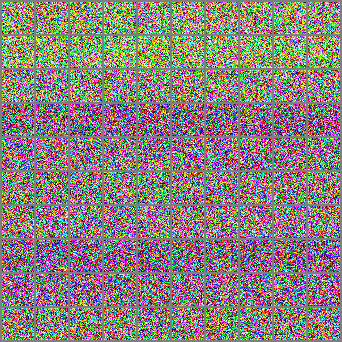


Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.224449
Epoch: 0, iteration: 50, loss: 0.114669
Epoch: 0, iteration: 100, loss: 0.077957
Epoch: 0, iteration: 150, loss: 0.0673039
Epoch: 0, iteration: 200, loss: 0.0620298
Epoch: 0, iteration: 250, loss: 0.0568484
Epoch: 0, iteration: 300, loss: 0.0554526
Epoch: 0, iteration: 350, loss: 0.0546361
Epoch: 0, iteration: 400, loss: 0.052572
Epoch: 0, iteration: 450, loss: 0.0553984
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.061849
Epoch: 1, iteration: 50, loss: 0.0499268
Epoch: 1, iteration: 100, loss: 0.049921
Epoch: 1, iteration: 150, loss: 0.0482212
Epoch: 1, iteration: 200, loss: 0.0470347
Epoch: 1, iteration: 250, loss: 0.0549215
Epoch: 1, iteration: 300, loss: 0.0520111
Epoch: 1, iteration: 350, loss: 0.0533543
Epoch: 1, iteration: 400, loss: 0.0482671
Epoch: 1, iteration: 450, loss: 0.0518679
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.0458913
Epoch: 2, iteration: 50, loss: 0.0519742
Epoch: 2, iteration: 100, loss: 0.042717
Epoch: 2, iteration: 150, loss: 0.0454467
Epoch: 2, iteration: 200, loss: 0.046441
Epoch: 2, iteration: 250, loss: 0.0505011
Epoch: 2, iteration: 300, loss: 0.0427808
Epoch: 2, iteration: 350, loss: 0.0436751
Epoch: 2, iteration: 400, loss: 0.0426401
Epoch: 2, iteration: 450, loss: 0.045755
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.0404466
Epoch: 3, iteration: 50, loss: 0.0457067
Epoch: 3, iteration: 100, loss: 0.0458742
Epoch: 3, iteration: 150, loss: 0.0531019
Epoch: 3, iteration: 200, loss: 0.0469088
Epoch: 3, iteration: 250, loss: 0.041616
Epoch: 3, iteration: 300, loss: 0.0433124
Epoch: 3, iteration: 350, loss: 0.0469589
Epoch: 3, iteration: 400, loss: 0.0403555
Epoch: 3, iteration: 450, loss: 0.0397717
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.0419628
Epoch: 4, iteration: 50, loss: 0.0420397
Epoch: 4, iteration: 100, loss: 0.0489997
Epoch: 4, iteration: 150, loss: 0.0426123
Epoch: 4, iteration: 200, loss: 0.0397729
Epoch: 4, iteration: 250, loss: 0.042129
Epoch: 4, iteration: 300, loss: 0.037721
Epoch: 4, iteration: 350, loss: 0.0437443
Epoch: 4, iteration: 400, loss: 0.0379749
Epoch: 4, iteration: 450, loss: 0.0456921

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 5, loss: 0.0391569

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

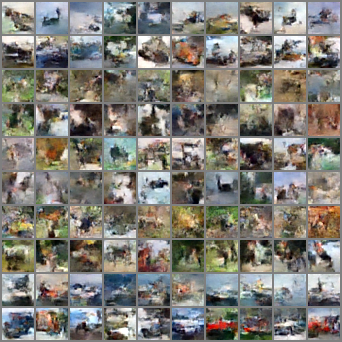


Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.0410497
Epoch: 5, iteration: 50, loss: 0.0431187
Epoch: 5, iteration: 100, loss: 0.0433673
Epoch: 5, iteration: 150, loss: 0.0437709
Epoch: 5, iteration: 200, loss: 0.0355657
Epoch: 5, iteration: 250, loss: 0.043068
Epoch: 5, iteration: 300, loss: 0.0356687
Epoch: 5, iteration: 350, loss: 0.0448176
Epoch: 5, iteration: 400, loss: 0.0443475
Epoch: 5, iteration: 450, loss: 0.042611
Epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.0422695
Epoch: 6, iteration: 50, loss: 0.0380781
Epoch: 6, iteration: 100, loss: 0.0358838
Epoch: 6, iteration: 150, loss: 0.044192
Epoch: 6, iteration: 200, loss: 0.0444046
Epoch: 6, iteration: 250, loss: 0.0434781
Epoch: 6, iteration: 300, loss: 0.0443887
Epoch: 6, iteration: 350, loss: 0.0402337
Epoch: 6, iteration: 400, loss: 0.0416461
Epoch: 6, iteration: 450, loss: 0.0397452
Epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.0405864
Epoch: 7, iteration: 50, loss: 0.0404036
Epoch: 7, iteration: 100, loss: 0.0387435
Epoch: 7, iteration: 150, loss: 0.0417862
Epoch: 7, iteration: 200, loss: 0.039431
Epoch: 7, iteration: 250, loss: 0.0372632
Epoch: 7, iteration: 300, loss: 0.0387399
Epoch: 7, iteration: 350, loss: 0.0380767
Epoch: 7, iteration: 400, loss: 0.0373749
Epoch: 7, iteration: 450, loss: 0.0410233
Epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.0420895
Epoch: 8, iteration: 50, loss: 0.040073
Epoch: 8, iteration: 100, loss: 0.0404505
Epoch: 8, iteration: 150, loss: 0.0423139
Epoch: 8, iteration: 200, loss: 0.0410444
Epoch: 8, iteration: 250, loss: 0.0408229
Epoch: 8, iteration: 300, loss: 0.0368324
Epoch: 8, iteration: 350, loss: 0.0402078
Epoch: 8, iteration: 400, loss: 0.0371016
Epoch: 8, iteration: 450, loss: 0.0441635
Epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.0405137
Epoch: 9, iteration: 50, loss: 0.0414493
Epoch: 9, iteration: 100, loss: 0.0351628
Epoch: 9, iteration: 150, loss: 0.0371048
Epoch: 9, iteration: 200, loss: 0.0347435
Epoch: 9, iteration: 250, loss: 0.0419556
Epoch: 9, iteration: 300, loss: 0.0398907
Epoch: 9, iteration: 350, loss: 0.0400685
Epoch: 9, iteration: 400, loss: 0.0393152
Epoch: 9, iteration: 450, loss: 0.0385848

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.0369752

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

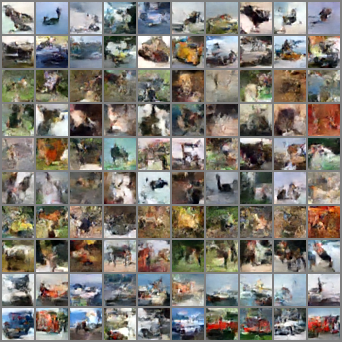


Epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.0394502
Epoch: 10, iteration: 50, loss: 0.0361772
Epoch: 10, iteration: 100, loss: 0.0369244
Epoch: 10, iteration: 150, loss: 0.0358647
Epoch: 10, iteration: 200, loss: 0.0362625
Epoch: 10, iteration: 250, loss: 0.0412595
Epoch: 10, iteration: 300, loss: 0.0427392
Epoch: 10, iteration: 350, loss: 0.0336629
Epoch: 10, iteration: 400, loss: 0.0333664
Epoch: 10, iteration: 450, loss: 0.0370006
Epoch 11


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.0370112
Epoch: 11, iteration: 50, loss: 0.0365108
Epoch: 11, iteration: 100, loss: 0.0405878
Epoch: 11, iteration: 150, loss: 0.044308
Epoch: 11, iteration: 200, loss: 0.0385691
Epoch: 11, iteration: 250, loss: 0.0414041
Epoch: 11, iteration: 300, loss: 0.0366287
Epoch: 11, iteration: 350, loss: 0.0401408
Epoch: 11, iteration: 400, loss: 0.0337361
Epoch: 11, iteration: 450, loss: 0.0369882
Epoch 12


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.0352796
Epoch: 12, iteration: 50, loss: 0.0427486
Epoch: 12, iteration: 100, loss: 0.0392817
Epoch: 12, iteration: 150, loss: 0.0400199
Epoch: 12, iteration: 200, loss: 0.0351656
Epoch: 12, iteration: 250, loss: 0.0358935
Epoch: 12, iteration: 300, loss: 0.0355141
Epoch: 12, iteration: 350, loss: 0.0390041
Epoch: 12, iteration: 400, loss: 0.0377866
Epoch: 12, iteration: 450, loss: 0.0404302
Epoch 13


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.0400662
Epoch: 13, iteration: 50, loss: 0.0442628
Epoch: 13, iteration: 100, loss: 0.0340042
Epoch: 13, iteration: 150, loss: 0.0385445
Epoch: 13, iteration: 200, loss: 0.0373314
Epoch: 13, iteration: 250, loss: 0.0359956
Epoch: 13, iteration: 300, loss: 0.0399265
Epoch: 13, iteration: 350, loss: 0.0393788
Epoch: 13, iteration: 400, loss: 0.044531
Epoch: 13, iteration: 450, loss: 0.0364858
Epoch 14


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.0398562
Epoch: 14, iteration: 50, loss: 0.0357058
Epoch: 14, iteration: 100, loss: 0.0323546
Epoch: 14, iteration: 150, loss: 0.0397739
Epoch: 14, iteration: 200, loss: 0.045717
Epoch: 14, iteration: 250, loss: 0.040608
Epoch: 14, iteration: 300, loss: 0.0393869
Epoch: 14, iteration: 350, loss: 0.0429126
Epoch: 14, iteration: 400, loss: 0.0414977
Epoch: 14, iteration: 450, loss: 0.0373401

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 15, loss: 0.0360384

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

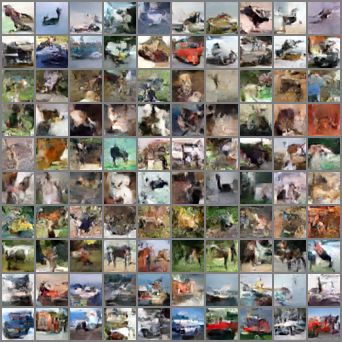


Epoch 15


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.0350624
Epoch: 15, iteration: 50, loss: 0.0370847
Epoch: 15, iteration: 100, loss: 0.0350736
Epoch: 15, iteration: 150, loss: 0.0453428
Epoch: 15, iteration: 200, loss: 0.037615
Epoch: 15, iteration: 250, loss: 0.0373351
Epoch: 15, iteration: 300, loss: 0.0315388
Epoch: 15, iteration: 350, loss: 0.0398169
Epoch: 15, iteration: 400, loss: 0.0367599
Epoch: 15, iteration: 450, loss: 0.0384234
Epoch 16


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.0392487
Epoch: 16, iteration: 50, loss: 0.0379947
Epoch: 16, iteration: 100, loss: 0.0415604
Epoch: 16, iteration: 150, loss: 0.040398
Epoch: 16, iteration: 200, loss: 0.0422457
Epoch: 16, iteration: 250, loss: 0.0421782
Epoch: 16, iteration: 300, loss: 0.0357828
Epoch: 16, iteration: 350, loss: 0.0344058
Epoch: 16, iteration: 400, loss: 0.0354624
Epoch: 16, iteration: 450, loss: 0.0380383
Epoch 17


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.0410689
Epoch: 17, iteration: 50, loss: 0.0378423
Epoch: 17, iteration: 100, loss: 0.0391851
Epoch: 17, iteration: 150, loss: 0.0373294
Epoch: 17, iteration: 200, loss: 0.0377661
Epoch: 17, iteration: 250, loss: 0.0379252
Epoch: 17, iteration: 300, loss: 0.0375741
Epoch: 17, iteration: 350, loss: 0.0431144
Epoch: 17, iteration: 400, loss: 0.039653
Epoch: 17, iteration: 450, loss: 0.0371804
Epoch 18


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.0354964
Epoch: 18, iteration: 50, loss: 0.039947
Epoch: 18, iteration: 100, loss: 0.0326413
Epoch: 18, iteration: 150, loss: 0.037453
Epoch: 18, iteration: 200, loss: 0.0332657
Epoch: 18, iteration: 250, loss: 0.0423393
Epoch: 18, iteration: 300, loss: 0.0349868
Epoch: 18, iteration: 350, loss: 0.0377503
Epoch: 18, iteration: 400, loss: 0.0349331
Epoch: 18, iteration: 450, loss: 0.0423167
Epoch 19


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.0287689
Epoch: 19, iteration: 50, loss: 0.038355
Epoch: 19, iteration: 100, loss: 0.0351406
Epoch: 19, iteration: 150, loss: 0.0401017
Epoch: 19, iteration: 200, loss: 0.0416271
Epoch: 19, iteration: 250, loss: 0.0380224
Epoch: 19, iteration: 300, loss: 0.0350142
Epoch: 19, iteration: 350, loss: 0.0345042
Epoch: 19, iteration: 400, loss: 0.0360057
Epoch: 19, iteration: 450, loss: 0.0346619

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.0355025

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

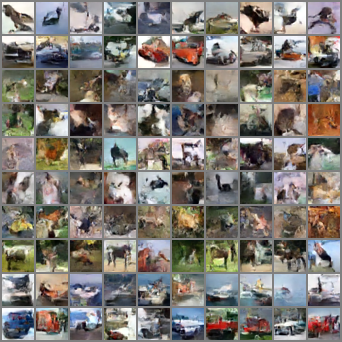


Epoch 20


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.0351087
Epoch: 20, iteration: 50, loss: 0.0356288
Epoch: 20, iteration: 100, loss: 0.0371565
Epoch: 20, iteration: 150, loss: 0.0371785
Epoch: 20, iteration: 200, loss: 0.0378243
Epoch: 20, iteration: 250, loss: 0.0356171
Epoch: 20, iteration: 300, loss: 0.0386342
Epoch: 20, iteration: 350, loss: 0.0387985
Epoch: 20, iteration: 400, loss: 0.0381292
Epoch: 20, iteration: 450, loss: 0.0412796
Epoch 21


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21, iteration: 0, loss: 0.0390852
Epoch: 21, iteration: 50, loss: 0.0402916
Epoch: 21, iteration: 100, loss: 0.0379448
Epoch: 21, iteration: 150, loss: 0.0406115
Epoch: 21, iteration: 200, loss: 0.0319809
Epoch: 21, iteration: 250, loss: 0.0368261
Epoch: 21, iteration: 300, loss: 0.0336982
Epoch: 21, iteration: 350, loss: 0.0368698
Epoch: 21, iteration: 400, loss: 0.0354414
Epoch: 21, iteration: 450, loss: 0.0336813
Epoch 22


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22, iteration: 0, loss: 0.035416
Epoch: 22, iteration: 50, loss: 0.037469
Epoch: 22, iteration: 100, loss: 0.0299779
Epoch: 22, iteration: 150, loss: 0.0389536
Epoch: 22, iteration: 200, loss: 0.0369016
Epoch: 22, iteration: 250, loss: 0.0409592
Epoch: 22, iteration: 300, loss: 0.0391988
Epoch: 22, iteration: 350, loss: 0.0350249
Epoch: 22, iteration: 400, loss: 0.0378473
Epoch: 22, iteration: 450, loss: 0.0376926
Epoch 23


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23, iteration: 0, loss: 0.0340752
Epoch: 23, iteration: 50, loss: 0.0340618
Epoch: 23, iteration: 100, loss: 0.0326796
Epoch: 23, iteration: 150, loss: 0.0374541
Epoch: 23, iteration: 200, loss: 0.0380488
Epoch: 23, iteration: 250, loss: 0.0343996
Epoch: 23, iteration: 300, loss: 0.0393087
Epoch: 23, iteration: 350, loss: 0.0329433
Epoch: 23, iteration: 400, loss: 0.0356183
Epoch: 23, iteration: 450, loss: 0.038062
Epoch 24


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24, iteration: 0, loss: 0.0368959
Epoch: 24, iteration: 50, loss: 0.038801
Epoch: 24, iteration: 100, loss: 0.0391423
Epoch: 24, iteration: 150, loss: 0.0352608
Epoch: 24, iteration: 200, loss: 0.0356356
Epoch: 24, iteration: 250, loss: 0.0393975
Epoch: 24, iteration: 300, loss: 0.0327452
Epoch: 24, iteration: 350, loss: 0.0387609
Epoch: 24, iteration: 400, loss: 0.0349284
Epoch: 24, iteration: 450, loss: 0.0441582

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 25, loss: 0.0349611

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

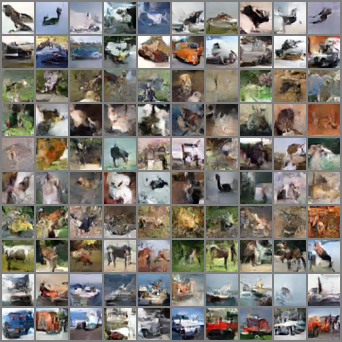


Epoch 25


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25, iteration: 0, loss: 0.0402079
Epoch: 25, iteration: 50, loss: 0.0361857
Epoch: 25, iteration: 100, loss: 0.0361545
Epoch: 25, iteration: 150, loss: 0.0349361
Epoch: 25, iteration: 200, loss: 0.0322853
Epoch: 25, iteration: 250, loss: 0.0378803
Epoch: 25, iteration: 300, loss: 0.0359659
Epoch: 25, iteration: 350, loss: 0.0436862
Epoch: 25, iteration: 400, loss: 0.0431059
Epoch: 25, iteration: 450, loss: 0.0406478
Epoch 26


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26, iteration: 0, loss: 0.0391153
Epoch: 26, iteration: 50, loss: 0.0408409
Epoch: 26, iteration: 100, loss: 0.0313775
Epoch: 26, iteration: 150, loss: 0.0345679
Epoch: 26, iteration: 200, loss: 0.0371479
Epoch: 26, iteration: 250, loss: 0.0371043
Epoch: 26, iteration: 300, loss: 0.0395154
Epoch: 26, iteration: 350, loss: 0.031999
Epoch: 26, iteration: 400, loss: 0.0381827
Epoch: 26, iteration: 450, loss: 0.032919
Epoch 27


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27, iteration: 0, loss: 0.0357634
Epoch: 27, iteration: 50, loss: 0.0368547
Epoch: 27, iteration: 100, loss: 0.0393275
Epoch: 27, iteration: 150, loss: 0.0378047
Epoch: 27, iteration: 200, loss: 0.0362908
Epoch: 27, iteration: 250, loss: 0.0374706
Epoch: 27, iteration: 300, loss: 0.0400602
Epoch: 27, iteration: 350, loss: 0.0360169
Epoch: 27, iteration: 400, loss: 0.035061
Epoch: 27, iteration: 450, loss: 0.03414
Epoch 28


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28, iteration: 0, loss: 0.0301627
Epoch: 28, iteration: 50, loss: 0.041749
Epoch: 28, iteration: 100, loss: 0.0335172
Epoch: 28, iteration: 150, loss: 0.0359046
Epoch: 28, iteration: 200, loss: 0.0330246
Epoch: 28, iteration: 250, loss: 0.0381914
Epoch: 28, iteration: 300, loss: 0.0325539
Epoch: 28, iteration: 350, loss: 0.0374011
Epoch: 28, iteration: 400, loss: 0.037329
Epoch: 28, iteration: 450, loss: 0.0456173
Epoch 29


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29, iteration: 0, loss: 0.0380576
Epoch: 29, iteration: 50, loss: 0.0337184
Epoch: 29, iteration: 100, loss: 0.0365404
Epoch: 29, iteration: 150, loss: 0.0449233
Epoch: 29, iteration: 200, loss: 0.0334165
Epoch: 29, iteration: 250, loss: 0.0329092
Epoch: 29, iteration: 300, loss: 0.0368464
Epoch: 29, iteration: 350, loss: 0.0383954
Epoch: 29, iteration: 400, loss: 0.0421846
Epoch: 29, iteration: 450, loss: 0.034233

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 30, loss: 0.0346616

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

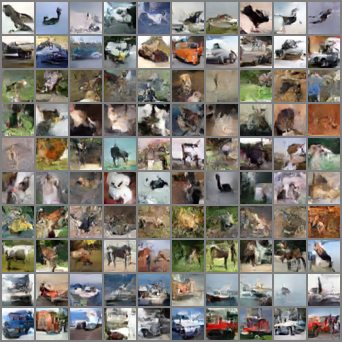

In [8]:
# Actually train the model

ema_decay = 0.998

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, log_snrs, classes)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    demo()
    while True:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 5 == 0:
            val()
            demo()
        save()
        if epoch == 30:
          break
except KeyboardInterrupt:
    pass
